In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import xgboost as xgb
from sklearn.metrics import confusion_matrix, adjusted_rand_score, roc_curve, auc, classification_report, f1_score, cohen_kappa_score
import plotly.graph_objects as go
from itertools import cycle, islice
from sklearn.preprocessing import label_binarize

import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=100, dpi_save=200)

In [ ]:
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

In [ ]:
#Defining class that contains functions that will perform the mapping with XGBoost and plot the results
class TimeMapping():
    
    # xgbclassifier will run the feature selection, training and validation, and testing
    def xgbclassifier(
        self,
        train_anndata,
        test_anndata,
        train_dict,
        test_dict,
        max_cells_per_ident = 700,
        train_frac = 0.7
        ): 

        self.train_dict = train_dict
        self.test_dict = test_dict

        self.numbertrainclasses = len(train_anndata.obs.Type.values.categories)
        self.numbertestclasses = len(test_anndata.obs.Type.values.categories)

        #Splitting the cell barcodes into a training set and validation set based on the minimum of 70% of cells or 700 cells
        #Creating array of the labels for each cell (the Type each cell barcode belongs too)
        training_set_train = []
        training_label_train = []

        for i in train_anndata.obs.Type.values.categories.values:
            cells_in_clust = train_anndata.obs.index[train_anndata.obs.Type.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train = np.hstack([training_set_train,train_temp])
            training_label_train = np.hstack([training_label_train,np.repeat(train_dict[i],len(train_temp))])

        training_set_test = []
        training_label_test = []

        for i in test_anndata.obs.Type.values.categories.values:
            cells_in_clust = test_anndata.obs.index[test_anndata.obs.Type.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_test = np.hstack([training_set_test,train_temp])
            training_label_test = np.hstack([training_label_test,np.repeat(test_dict[i],len(train_temp))])

        train_index_train = []
        for i in training_set_train:
            train_index_train.append(np.where(train_anndata.obs.index.values == i)[0][0])

        train_index_test = []
        for i in training_set_test:
            train_index_test.append(np.where(test_anndata.obs.index.values == i)[0][0])

        train_matrix_train = xgb.DMatrix(data = train_anndata.raw.X.A[train_index_train,:], label = training_label_train, feature_names = train_anndata.var.index.values)

        train_matrix_test = xgb.DMatrix(data = test_anndata.raw.X.A[train_index_test,:], label = training_label_test, feature_names = test_anndata.var.index.values)

        del training_set_train, training_label_train, training_set_test, training_label_test, train_index_train, train_index_test

        #Defining parameters for the XGBoost Model
        xgb_params_train = {
            'objective':'multi:softprob',
            'eval_metric':'mlogloss',
            'num_class':self.numbertrainclasses,
            'eta':0.2,
            'max_depth':6,
            'subsample': 0.6}
        nround = 200

        #Fitting the XGBoost Model to the training data
        bst_model_train = xgb.train(
            params = xgb_params_train,
            dtrain = train_matrix_train,
            num_boost_round = nround)

        xgb_params_test = {
            'objective':'multi:softprob',
            'eval_metric':'mlogloss',
            'num_class':self.numbertestclasses,
            'eta':0.2,
            'max_depth':6,
            'subsample': 0.6}
        nround = 200

        #Fitting the XGBoost Model to the testing data
        bst_model_test = xgb.train(
            params = xgb_params_test,
            dtrain = train_matrix_test,
            num_boost_round = nround)

        train_xgboost_scores = bst_model_train.get_score(importance_type="gain")
        sort_train_scores = {k: v for k, v in sorted(train_xgboost_scores.items(), key=lambda item: item[1], reverse = True)[:500]}
        top500genestrain = list(sort_train_scores.keys())

        test_xgboost_scores = bst_model_test.get_score(importance_type="gain")
        sort_test_scores = {k: v for k, v in sorted(test_xgboost_scores.items(), key=lambda item: item[1], reverse = True)[:500]}
        top500genestest = list(sort_test_scores.keys())

        common_top_genes = np.array([i for i in top500genestrain if i in top500genestest]) #These are the features that we will use for training, validating and testing

        del train_matrix_train, train_matrix_test, bst_model_train, bst_model_test, train_xgboost_scores, sort_train_scores, top500genestrain, test_xgboost_scores, sort_test_scores, top500genestest

        #Train XGBoost on 70% of training data and validate on the remaining data
        common_top_genes_index_train = []
        for i in common_top_genes:
            common_top_genes_index_train.append(np.where(train_anndata.var.index.values == i)[0][0])

        training_set_train_70 = []
        validation_set_train_70 = []
        training_label_train_70 = []
        validation_label_train_70 = []

        for i in train_anndata.obs.Type.values.categories.values:
            cells_in_clust = train_anndata.obs.index[train_anndata.obs.Type.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            validation_temp = np.setdiff1d(cells_in_clust, train_temp)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train_70 = np.hstack([training_set_train_70,train_temp])
            validation_set_train_70 = np.hstack([validation_set_train_70,validation_temp])
            training_label_train_70 = np.hstack([training_label_train_70,np.repeat(train_dict[i],len(train_temp))])
            validation_label_train_70 = np.hstack([validation_label_train_70,np.repeat(train_dict[i],len(validation_temp))])

        train_index_train_70 = []
        for i in training_set_train_70:
            train_index_train_70.append(np.where(train_anndata.obs.index.values == i)[0][0])
        validation_index_train_70 = []
        for i in validation_set_train_70:
            validation_index_train_70.append(np.where(train_anndata.obs.index.values == i)[0][0])

        train_matrix_train_70 = xgb.DMatrix(data = train_anndata.raw.X.A[:,common_top_genes_index_train][train_index_train_70,:], label = training_label_train_70)
        validation_matrix_train_70 = xgb.DMatrix(data = train_anndata.raw.X.A[:,common_top_genes_index_train][validation_index_train_70,:], label = validation_label_train_70)

        del training_set_train_70, validation_set_train_70, training_label_train_70, train_index_train_70, validation_index_train_70

        bst_model_train_70 = xgb.train(
            params = xgb_params_train,
            dtrain = train_matrix_train_70,
            num_boost_round = nround)

        validation_pred_train_70 = bst_model_train_70.predict(data = validation_matrix_train_70)

        valid_predlabels_train_70 = np.zeros((validation_pred_train_70.shape[0]))
        for i in range(validation_pred_train_70.shape[0]):
            valid_predlabels_train_70[i] = np.argmax(validation_pred_train_70[i,:])
        
        f1 = f1_score(validation_label_train_70, valid_predlabels_train_70, average = None)
        
        del train_matrix_train_70, validation_matrix_train_70, validation_pred_train_70

        #Train XGBoost on the full training data
        training_set_train_full = []
        training_label_train_full = []

        for i in train_anndata.obs.Type.values.categories.values:
            train_temp = train_anndata.obs.index[train_anndata.obs.Type.values == i]
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train_full = np.hstack([training_set_train_full,train_temp])
            training_label_train_full = np.hstack([training_label_train_full,np.repeat(train_dict[i],len(train_temp))])

        train_index_full = []
        for i in training_set_train_full:
            train_index_full.append(np.where(train_anndata.obs.index.values == i)[0][0])

        full_training_data = xgb.DMatrix(data = train_anndata.raw.X.A[:,common_top_genes_index_train][train_index_full,:], label = training_label_train_full)

        del common_top_genes_index_train, training_set_train_full, training_label_train_full, train_index_full

        bst_model_full_train = xgb.train(
            params = xgb_params_train,
            dtrain = full_training_data,
            num_boost_round = nround)

        #Predict the testing Type labels
        common_top_genes_index_test = []
        for i in common_top_genes:
            common_top_genes_index_test.append(np.where(test_anndata.var.index.values == i)[0][0])

        full_testing_data = xgb.DMatrix(data = test_anndata.raw.X.A[:,common_top_genes_index_test])
        test_prediction = bst_model_full_train.predict(data = full_testing_data)

        del bst_model_full_train, full_testing_data

        test_predlabels = np.zeros((test_prediction.shape[0]))
        for i in range(test_prediction.shape[0]):
            if np.max(test_prediction[i,:]) > 1.1*(1/self.numbertrainclasses):
                test_predlabels[i] = np.argmax(test_prediction[i,:])
            else:
                test_predlabels[i] = self.numbertrainclasses

        test_labels = np.zeros(len(test_anndata.obs.Type.values))
        for i,l in enumerate(test_anndata.obs.Type.values):
            test_labels[i] = test_dict[l]

        return validation_label_train_70, valid_predlabels_train_70, test_labels, test_predlabels

    #plotConfusionMatrix will take the results from the xgboost classifier and plot them
    def plotConfusionMatrix(
        self,
        ytrue,
        ypred,
        type,
        save_as,
        title = '',
        xaxislabel = '',
        yaxislabel = ''
        ):

        confusionmatrix = confusion_matrix(y_true = ytrue, y_pred = ypred)
        if type == 'mapping':
          if self.numbertrainclasses in ypred:
            confusionmatrix = confusionmatrix[0:self.numbertestclasses,0:self.numbertrainclasses]
          else:
            confusionmatrix = confusionmatrix[0:self.numbertestclasses,0:self.numbertrainclasses]
        confmatpercent = np.zeros(confusionmatrix.shape)
        for i in range(confusionmatrix.shape[0]):
          if np.sum(confusionmatrix[i,:]) != 0:
            confmatpercent[i,:] = confusionmatrix[i,:]/np.sum(confusionmatrix[i,:])
          else:
            confmatpercent[i,:] = confusionmatrix[i,:]
        diagcm = confmatpercent
        xticks = np.linspace(0, confmatpercent.shape[1]-1, confmatpercent.shape[1], dtype = int)
        xticksactual = []
        for i in xticks:
        #  if i != self.numbertrainclasses:
          xticksactual.append(list(self.train_dict.keys())[i])
        #  else:
        #    xticksactual.append('Unassigned')
        dot_max = np.max(diagcm.flatten())
        dot_min = 0
        if dot_min != 0 or dot_max != 1:
            frac = np.clip(diagcm, dot_min, dot_max)
            old_range = dot_max - dot_min
            frac = (frac - dot_min) / old_range
        else:
            frac = diagcm
        xvalues = []
        yvalues = []
        sizes = []
        for i in range(diagcm.shape[0]):
            for j in range(diagcm.shape[1]):
                xvalues.append(j)
                yvalues.append(i)
                sizes.append((frac[i,j]*35)**1.5)
        size_legend_width = 0.5
        height = diagcm.shape[0] * 0.3 + 1
        height = max([1.5, height])
        heatmap_width = diagcm.shape[1] * 0.35
        width = (
            heatmap_width
            + size_legend_width
            )
        fig = plt.figure(figsize=(width, height))
        axs = gridspec.GridSpec(
            nrows=2,
            ncols=2,
            wspace=0.02,
            hspace=0.04,
            width_ratios=[
                        heatmap_width,
                        size_legend_width
                        ],
            height_ratios = [0.5, 10]
            )
        dot_ax = fig.add_subplot(axs[1, 0])
        dot_ax.scatter(xvalues,yvalues, s = sizes, c = 'blue', norm=None, edgecolor='none')
        y_ticks = range(diagcm.shape[0])
        dot_ax.set_yticks(y_ticks)
        if type == 'validation':
          dot_ax.set_yticklabels(list(self.train_dict.keys()))
        elif type == 'mapping':
          dot_ax.set_yticklabels(list(self.test_dict.keys()))
        x_ticks = range(diagcm.shape[1])
        dot_ax.set_xticks(x_ticks)
        dot_ax.set_xticklabels(xticksactual, rotation=90)
        dot_ax.tick_params(axis='both', labelsize='small')
        dot_ax.grid(True, linewidth = 0.2)
        dot_ax.set_axisbelow(True)
        dot_ax.set_xlim(-0.5, diagcm.shape[1] + 0.5)
        ymin, ymax = dot_ax.get_ylim()
        dot_ax.set_ylim(ymax + 0.5, ymin - 0.5)
        dot_ax.set_xlim(-1, diagcm.shape[1])
        dot_ax.set_xlabel(xaxislabel)
        dot_ax.set_ylabel(yaxislabel)
        dot_ax.set_title(title)
        size_legend_height = min(1.75, height)
        wspace = 10.5 / width
        axs3 = gridspec.GridSpecFromSubplotSpec(
            2,
            1,
            subplot_spec=axs[1, 1],
            wspace=wspace,
            height_ratios=[
                        size_legend_height / height,
                        (height - size_legend_height) / height
                        ]
            )
        diff = dot_max - dot_min
        if 0.3 < diff <= 0.6:
            step = 0.1
        elif diff <= 0.3:
            step = 0.05
        else:
            step = 0.2
        fracs_legends = np.arange(dot_max, dot_min, step * -1)[::-1]
        if dot_min != 0 or dot_max != 1:
            fracs_values = (fracs_legends - dot_min) / old_range
        else:
            fracs_values = fracs_legends
        size = (fracs_values * 35) ** 1.5
        size_legend = fig.add_subplot(axs3[0])
        size_legend.scatter(np.repeat(0, len(size)), range(len(size)), s=size, c = 'blue')
        size_legend.set_yticks(range(len(size)))
        labels = ["{:.0%}".format(x) for x in fracs_legends]
        if dot_max < 1:
            labels[-1] = ">" + labels[-1]
        size_legend.set_yticklabels(labels)
        size_legend.set_yticklabels(["{:.0%}".format(x) for x in fracs_legends])
        size_legend.tick_params(axis='y', left=False, labelleft=False, labelright=True)
        size_legend.tick_params(axis='x', bottom=False, labelbottom=False)
        size_legend.spines['right'].set_visible(False)
        size_legend.spines['top'].set_visible(False)
        size_legend.spines['left'].set_visible(False)
        size_legend.spines['bottom'].set_visible(False)
        size_legend.grid(False)
        ymin, ymax = size_legend.get_ylim()
        size_legend.set_ylim(ymin, ymax + 0.5)
        fig.savefig(save_as, bbox_inches = 'tight')

        return diagcm, xticksactual, axs

In [ ]:
def calculateNCE(labels_true,labels_pred):
    X = labels_true
    Y = labels_pred
    contTable = confusion_matrix(X,Y)[0:len(np.unique(X)), 0:len(np.unique(Y))]
    a = np.sum(contTable, axis = 1)
    b = np.sum(contTable, axis = 0)
    N = np.sum(contTable)
    pij = contTable/N
    pi = a/N
    pj = b/N
    Hyx = np.zeros(contTable.shape)
    for i in range(contTable.shape[0]):
        for j in range(contTable.shape[1]):
          if pij[i,j] == 0:
            Hyx[i,j] = 0
          else:
            Hyx[i,j] = pij[i,j]*np.log10(pij[i,j]/pi[i])
    CE = -np.sum(Hyx)
    Hyi = np.zeros(contTable.shape[1])
    for j in range(contTable.shape[1]):
      if pj[j] == 0:
       Hyi[j] = 0
      else:
        Hyi[j] = pj[j]*np.log10(pj[j])
    Hy = -np.sum(Hyi)
    NCE = CE/Hy
    return NCE

In [ ]:
def Pvalb_cells(adata):
  Pvalbcells = []
  for i in range(len(adata.obs)):
    if adata.obs.Type[i] in ['Pvalb_A', 'Pvalb_B', 'Pvalb_C', 'Pvalb_D']:
      Pvalbcells.append(adata.obs.index[i])
  return Pvalbcells

def Sst_cells(adata):
  Sstcells = []
  for i in range(len(adata.obs)):
    if adata.obs.Type[i] in ['Sst_A', 'Sst_B', 'Sst_C', 'Sst_D', 'Sst_E']:
      Sstcells.append(adata.obs.index[i])
  return Sstcells

def Vip_cells(adata):
  Vipcells = []
  for i in range(len(adata.obs)):
    if adata.obs.Type[i] in ['Vip_A', 'Vip_B', 'Vip_C']:
      Vipcells.append(adata.obs.index[i])
  return Vipcells

In [ ]:
#Loading in the corresponding h5ad files
P8_adata = sc.read_h5ad('P8_gaba_March.h5ad')
P14_adata = sc.read_h5ad('P14_gaba_March.h5ad')
P17_adata = sc.read_h5ad('P17_gaba_March.h5ad')
P21_adata = sc.read_h5ad('P21_gaba_March.h5ad')
P28_adata = sc.read_h5ad('P28_gaba_March.h5ad')
P38_adata = sc.read_h5ad('P38_gaba_March.h5ad')

In [ ]:
save_path = ''

# P8-P14

In [ ]:
P8_Pvalb_dict = {'Pvalb_A':0, 'Pvalb_B':1, 'Pvalb_C':2, 'Pvalb_D':3}
P8_Sst_dict = {'Sst_A':0, 'Sst_B':1, 'Sst_C':2, 'Sst_D':3, 'Sst_E':4}
P8_Vip_dict = {'Vip_A':0, 'Vip_B':1}

P14_Pvalb_dict = {'Pvalb_A':0, 'Pvalb_B':1, 'Pvalb_C':2, 'Pvalb_D':3}
P14_Sst_dict = {'Sst_A':0, 'Sst_B':1, 'Sst_C':2, 'Sst_D':3, 'Sst_E':4}
P14_Vip_dict = {'Vip_A':0, 'Vip_B':1, 'Vip_C':2}

## Pvalb

In [ ]:
P8_Pvalb_cells = Pvalb_cells(P8_adata)
P14_Pvalb_cells = Pvalb_cells(P14_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P8vsP14, valid_predlabels_train_70P8vsP14, test_labelsP8vsP14, test_predlabelsP8vsP14 = tm.xgbclassifier(
    train_anndata = P14_adata[P14_Pvalb_cells,:],
    test_anndata = P8_adata[P8_Pvalb_cells,:],
    train_dict = P14_Pvalb_dict,
    test_dict = P8_Pvalb_dict
    )

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


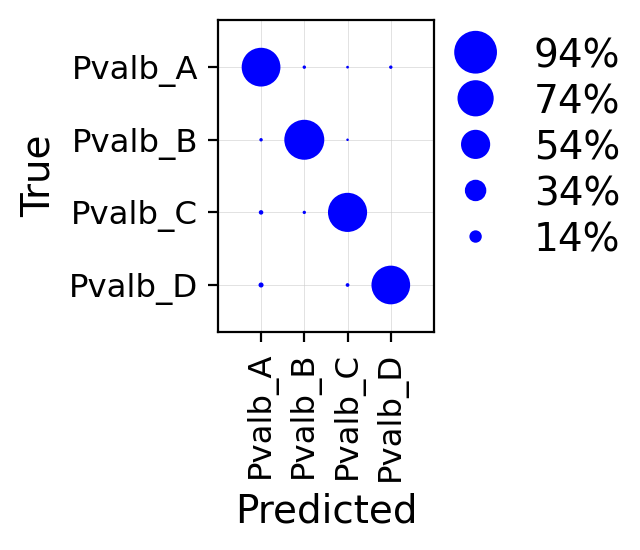

In [ ]:
validationconfmatP8vsP14, validationxticksP8vsP14, validationplotP8vsP14 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P8vsP14,
    ypred = valid_predlabels_train_70P8vsP14,
    type = 'validation',
    save_as = save_path + 'P8_P14/Pvalb_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

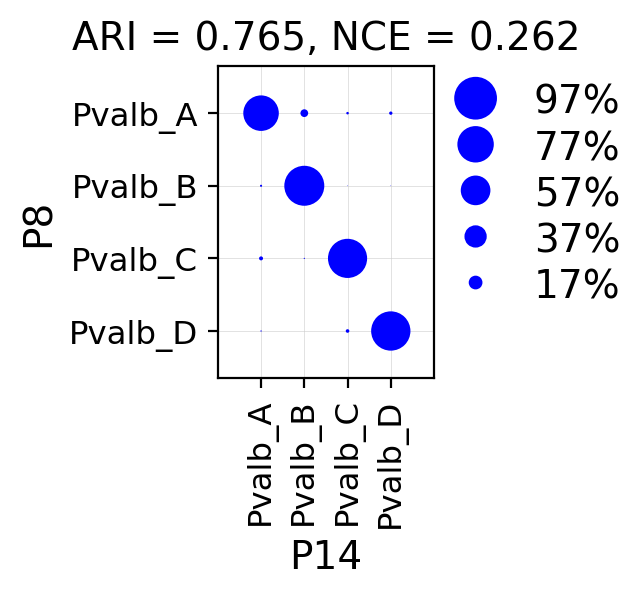

In [ ]:
mappingconfmatP8vsP14, mappingxticksP8vsP14, mappingplotP8vsP14 = tm.plotConfusionMatrix(
    ytrue = test_labelsP8vsP14,
    ypred = test_predlabelsP8vsP14,
    type = 'mapping',
    save_as = save_path + 'P8_P14/Pvalb_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14), calculateNCE(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14)),
    xaxislabel = 'P14',
    yaxislabel = 'P8'
    )

In [ ]:
ARI_Pvalb = []
NCE_Pvalb = []
ARI_Pvalb.append(adjusted_rand_score(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14))
NCE_Pvalb.append(calculateNCE(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14))

## Sst

In [ ]:
P8_Sst_cells = Sst_cells(P8_adata)
P14_Sst_cells = Sst_cells(P14_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P8vsP14, valid_predlabels_train_70P8vsP14, test_labelsP8vsP14, test_predlabelsP8vsP14 = tm.xgbclassifier(
    train_anndata = P14_adata[P14_Sst_cells,:],
    test_anndata = P8_adata[P8_Sst_cells,:],
    train_dict = P14_Sst_dict,
    test_dict = P8_Sst_dict
    )

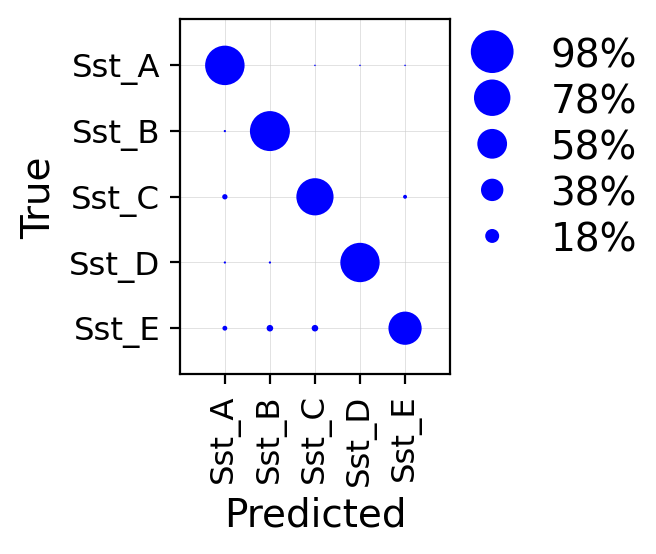

In [ ]:
validationconfmatP8vsP14, validationxticksP8vsP14, validationplotP8vsP14 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P8vsP14,
    ypred = valid_predlabels_train_70P8vsP14,
    type = 'validation',
    save_as = save_path + 'P8_P14/Sst_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

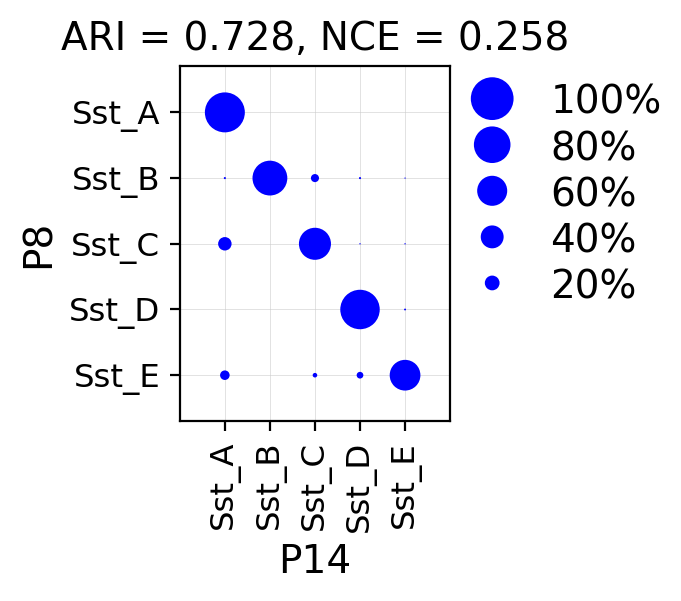

In [ ]:
mappingconfmatP8vsP14, mappingxticksP8vsP14, mappingplotP8vsP14 = tm.plotConfusionMatrix(
    ytrue = test_labelsP8vsP14,
    ypred = test_predlabelsP8vsP14,
    type = 'mapping',
    save_as = save_path + 'P8_P14/Sst_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14), calculateNCE(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14)),
    xaxislabel = 'P14',
    yaxislabel = 'P8'
    )

In [ ]:
ARI_Sst = []
NCE_Sst = []
ARI_Sst.append(adjusted_rand_score(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14))
NCE_Sst.append(calculateNCE(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14))

## Vip

In [ ]:
P8_Vip_cells = Vip_cells(P8_adata)
P14_Vip_cells = Vip_cells(P14_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P8vsP14, valid_predlabels_train_70P8vsP14, test_labelsP8vsP14, test_predlabelsP8vsP14 = tm.xgbclassifier(
    train_anndata = P14_adata[P14_Vip_cells,:],
    test_anndata = P8_adata[P8_Vip_cells,:],
    train_dict = P14_Vip_dict,
    test_dict = P8_Vip_dict
    )

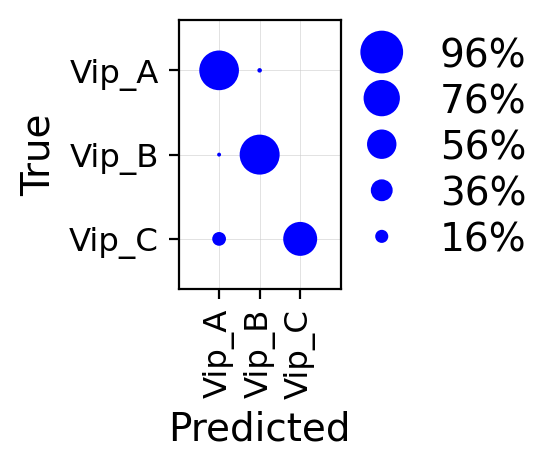

In [ ]:
validationconfmatP8vsP14, validationxticksP8vsP14, validationplotP8vsP14 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P8vsP14,
    ypred = valid_predlabels_train_70P8vsP14,
    type = 'validation',
    save_as = save_path + 'P8_P14/Vip_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

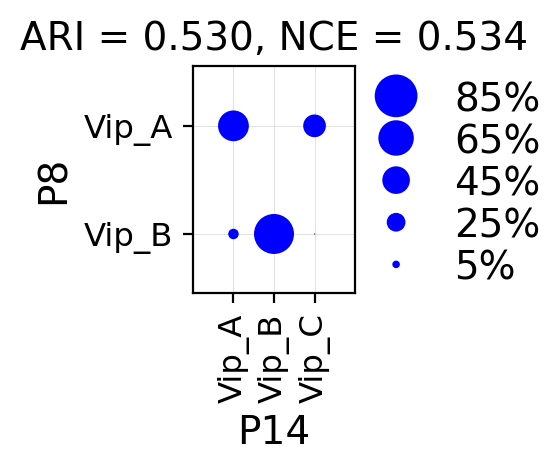

In [ ]:
mappingconfmatP8vsP14, mappingxticksP8vsP14, mappingplotP8vsP14 = tm.plotConfusionMatrix(
    ytrue = test_labelsP8vsP14,
    ypred = test_predlabelsP8vsP14,
    type = 'mapping',
    save_as = save_path + 'P8_P14/Vip_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14), calculateNCE(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14)),
    xaxislabel = 'P14',
    yaxislabel = 'P8'
    )

In [ ]:
ARI_Vip = []
NCE_Vip = []
ARI_Vip.append(adjusted_rand_score(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14))
NCE_Vip.append(calculateNCE(labels_true = test_labelsP8vsP14, labels_pred = test_predlabelsP8vsP14))

# P14-P17

In [ ]:
P14_Pvalb_dict = {'Pvalb_A':0, 'Pvalb_B':1, 'Pvalb_C':2, 'Pvalb_D':3}
P14_Sst_dict = {'Sst_A':0, 'Sst_B':1, 'Sst_C':2, 'Sst_D':3, 'Sst_E':4}
P14_Vip_dict = {'Vip_A':0, 'Vip_B':1, 'Vip_C':2}

P17_Pvalb_dict = {'Pvalb_A':0, 'Pvalb_B':1, 'Pvalb_C':2, 'Pvalb_D':3}
P17_Sst_dict = {'Sst_A':0, 'Sst_B':1, 'Sst_C':2, 'Sst_D':3, 'Sst_E':4}
P17_Vip_dict = {'Vip_A':0, 'Vip_B':1, 'Vip_C':2}

## Pvalb

In [ ]:
P14_Pvalb_cells = Pvalb_cells(P14_adata)
P17_Pvalb_cells = Pvalb_cells(P17_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P14vsP17, valid_predlabels_train_70P14vsP17, test_labelsP14vsP17, test_predlabelsP14vsP17 = tm.xgbclassifier(
    train_anndata = P17_adata[P17_Pvalb_cells,:],
    test_anndata = P14_adata[P14_Pvalb_cells,:],
    train_dict = P17_Pvalb_dict,
    test_dict = P14_Pvalb_dict
    )

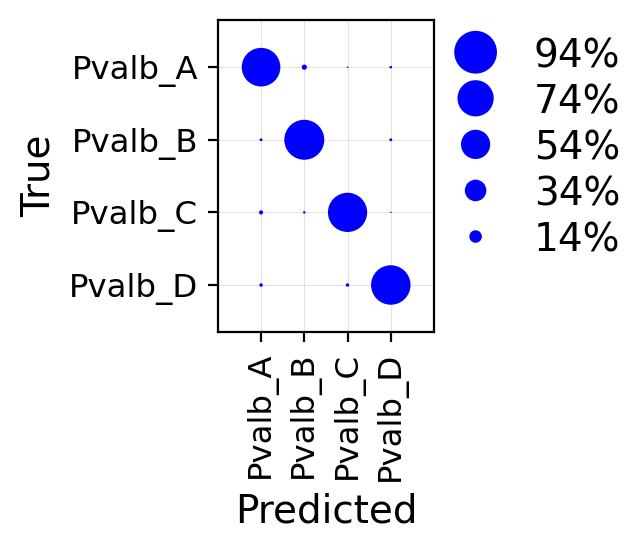

In [ ]:
validationconfmatP14vsP17, validationxticksP14vsP17, validationplotP14vsP17 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P14vsP17,
    ypred = valid_predlabels_train_70P14vsP17,
    type = 'validation',
    save_as = save_path + 'P14_P17/Pvalb_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

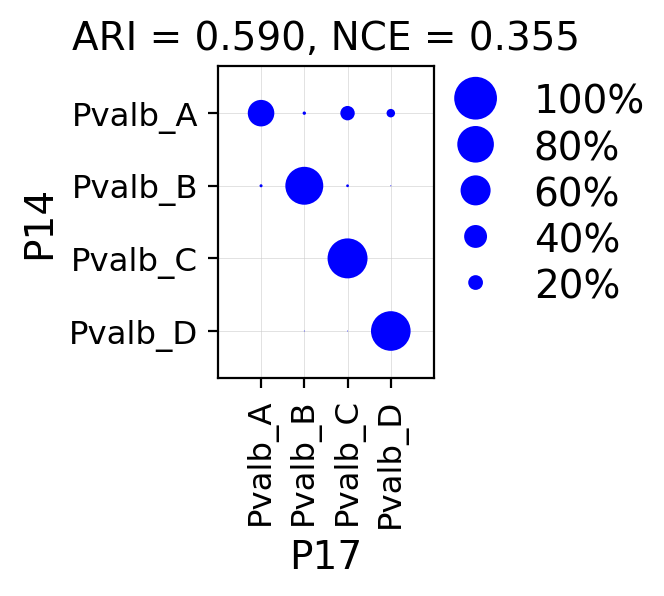

In [ ]:
mappingconfmatP14vsP17, mappingxticksP14vsP17, mappingplotP14vsP17 = tm.plotConfusionMatrix(
    ytrue = test_labelsP14vsP17,
    ypred = test_predlabelsP14vsP17,
    type = 'mapping',
    save_as = save_path + 'P14_P17/Pvalb_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17), calculateNCE(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17)),
    xaxislabel = 'P17',
    yaxislabel = 'P14'
    )

In [ ]:
ARI_Pvalb.append(adjusted_rand_score(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17))
NCE_Pvalb.append(calculateNCE(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17))

## Sst

In [ ]:
P14_Sst_cells = Sst_cells(P14_adata)
P17_Sst_cells = Sst_cells(P17_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P14vsP17, valid_predlabels_train_70P14vsP17, test_labelsP14vsP17, test_predlabelsP14vsP17 = tm.xgbclassifier(
    train_anndata = P17_adata[P17_Sst_cells,:],
    test_anndata = P14_adata[P14_Sst_cells,:],
    train_dict = P17_Sst_dict,
    test_dict = P14_Sst_dict
    )

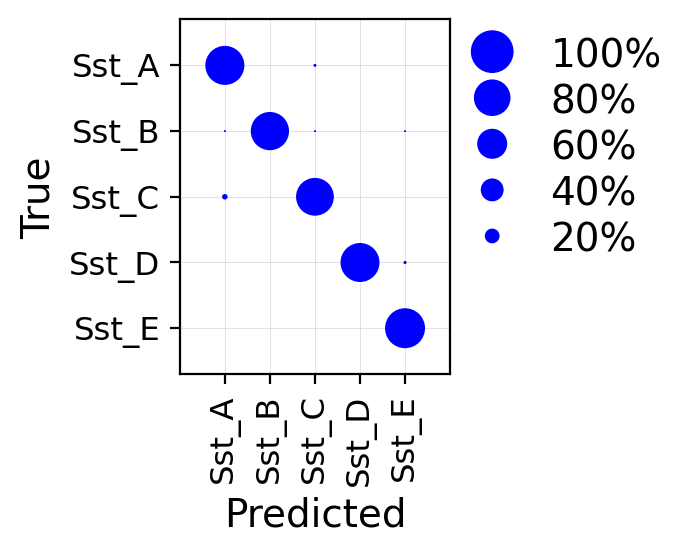

In [ ]:
validationconfmatP14vsP17, validationxticksP14vsP17, validationplotP14vsP17 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P14vsP17,
    ypred = valid_predlabels_train_70P14vsP17,
    type = 'validation',
    save_as = save_path + 'P14_P17/Sst_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

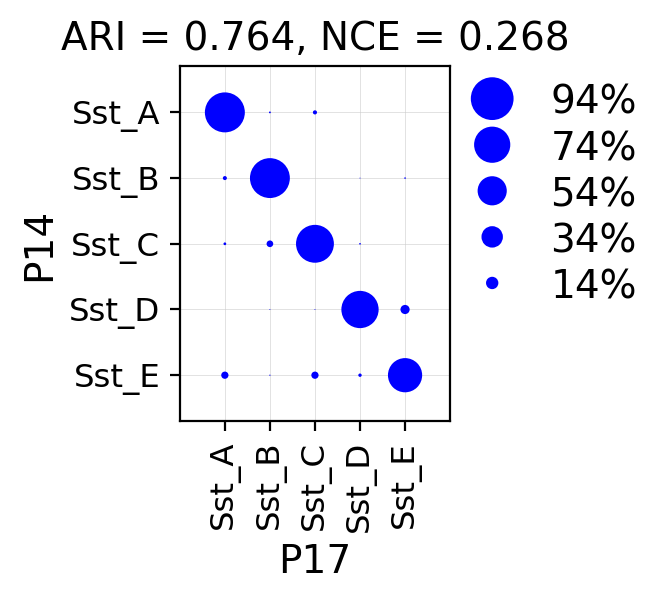

In [ ]:
mappingconfmatP14vsP17, mappingxticksP14vsP17, mappingplotP14vsP17 = tm.plotConfusionMatrix(
    ytrue = test_labelsP14vsP17,
    ypred = test_predlabelsP14vsP17,
    type = 'mapping',
    save_as = save_path + 'P14_P17/Sst_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17), calculateNCE(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17)),
    xaxislabel = 'P17',
    yaxislabel = 'P14'
    )

In [ ]:
ARI_Sst.append(adjusted_rand_score(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17))
NCE_Sst.append(calculateNCE(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17))

## Vip

In [ ]:
P14_Vip_cells = Vip_cells(P14_adata)
P17_Vip_cells = Vip_cells(P17_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P14vsP17, valid_predlabels_train_70P14vsP17, test_labelsP14vsP17, test_predlabelsP14vsP17 = tm.xgbclassifier(
    train_anndata = P17_adata[P17_Vip_cells,:],
    test_anndata = P14_adata[P14_Vip_cells,:],
    train_dict = P17_Vip_dict,
    test_dict = P14_Vip_dict
    )

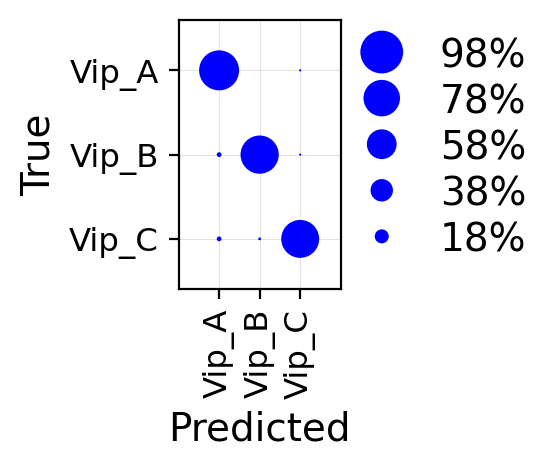

In [ ]:
validationconfmatP14vsP17, validationxticksP14vsP17, validationplotP14vsP17 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P14vsP17,
    ypred = valid_predlabels_train_70P14vsP17,
    type = 'validation',
    save_as = save_path + 'P14_P17/Vip_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

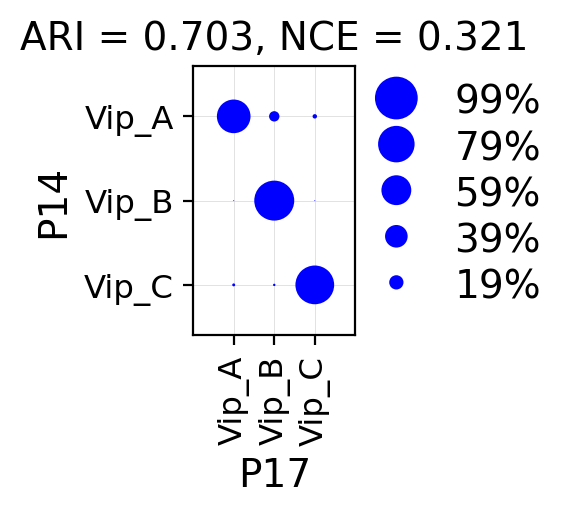

In [ ]:
mappingconfmatP14vsP17, mappingxticksP14vsP17, mappingplotP14vsP17 = tm.plotConfusionMatrix(
    ytrue = test_labelsP14vsP17,
    ypred = test_predlabelsP14vsP17,
    type = 'mapping',
    save_as = save_path + 'P14_P17/Vip_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17), calculateNCE(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17)),
    xaxislabel = 'P17',
    yaxislabel = 'P14'
    )

In [ ]:
ARI_Vip.append(adjusted_rand_score(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17))
NCE_Vip.append(calculateNCE(labels_true = test_labelsP14vsP17, labels_pred = test_predlabelsP14vsP17))

# P17-P21

In [ ]:
P17_Pvalb_dict = {'Pvalb_A':0, 'Pvalb_B':1, 'Pvalb_C':2, 'Pvalb_D':3}
P17_Sst_dict = {'Sst_A':0, 'Sst_B':1, 'Sst_C':2, 'Sst_D':3, 'Sst_E':4}
P17_Vip_dict = {'Vip_A':0, 'Vip_B':1, 'Vip_C':2}

P21_Pvalb_dict = {'Pvalb_A':0, 'Pvalb_B':1, 'Pvalb_C':2, 'Pvalb_D':3}
P21_Sst_dict = {'Sst_A':0, 'Sst_B':1, 'Sst_C':2, 'Sst_D':3, 'Sst_E':4}
P21_Vip_dict = {'Vip_A':0, 'Vip_B':1, 'Vip_C':2}

## Pvalb

In [ ]:
P17_Pvalb_cells = Pvalb_cells(P17_adata)
P21_Pvalb_cells = Pvalb_cells(P21_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P17vsP21, valid_predlabels_train_70P17vsP21, test_labelsP17vsP21, test_predlabelsP17vsP21 = tm.xgbclassifier(
    train_anndata = P21_adata[P21_Pvalb_cells,:],
    test_anndata = P17_adata[P17_Pvalb_cells,:],
    train_dict = P21_Pvalb_dict,
    test_dict = P17_Pvalb_dict
    )

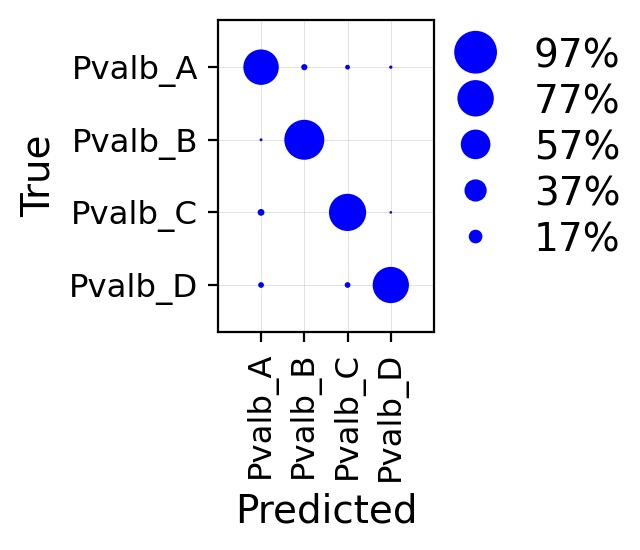

In [ ]:
validationconfmatP17vsP21, validationxticksP17vsP21, validationplotP17vsP21 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P17vsP21,
    ypred = valid_predlabels_train_70P17vsP21,
    type = 'validation',
    save_as = save_path + 'P17_P21/Pvalb_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

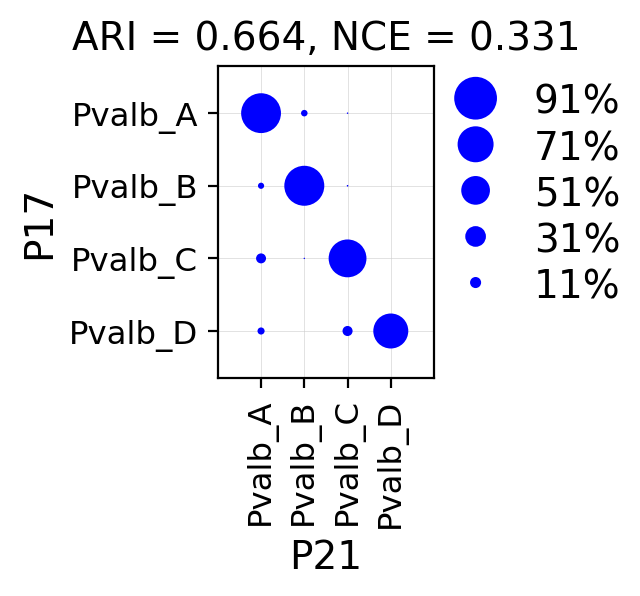

In [ ]:
mappingconfmatP17vsP21, mappingxticksP17vsP21, mappingplotP17vsP21 = tm.plotConfusionMatrix(
    ytrue = test_labelsP17vsP21,
    ypred = test_predlabelsP17vsP21,
    type = 'mapping',
    save_as = save_path + 'P17_P21/Pvalb_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21), calculateNCE(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21)),
    xaxislabel = 'P21',
    yaxislabel = 'P17'
    )

In [ ]:
ARI_Pvalb.append(adjusted_rand_score(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21))
NCE_Pvalb.append(calculateNCE(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21))

## Sst

In [ ]:
P17_Sst_cells = Sst_cells(P17_adata)
P21_Sst_cells = Sst_cells(P21_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P17vsP21, valid_predlabels_train_70P17vsP21, test_labelsP17vsP21, test_predlabelsP17vsP21 = tm.xgbclassifier(
    train_anndata = P21_adata[P21_Sst_cells,:],
    test_anndata = P17_adata[P17_Sst_cells,:],
    train_dict = P21_Sst_dict,
    test_dict = P17_Sst_dict
    )

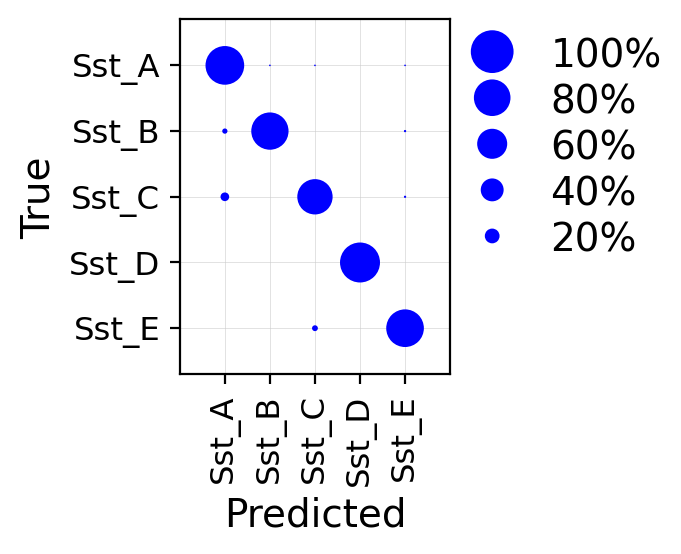

In [ ]:
validationconfmatP17vsP21, validationxticksP17vsP21, validationplotP17vsP21 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P17vsP21,
    ypred = valid_predlabels_train_70P17vsP21,
    type = 'validation',
    save_as = save_path + 'P17_P21/Sst_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

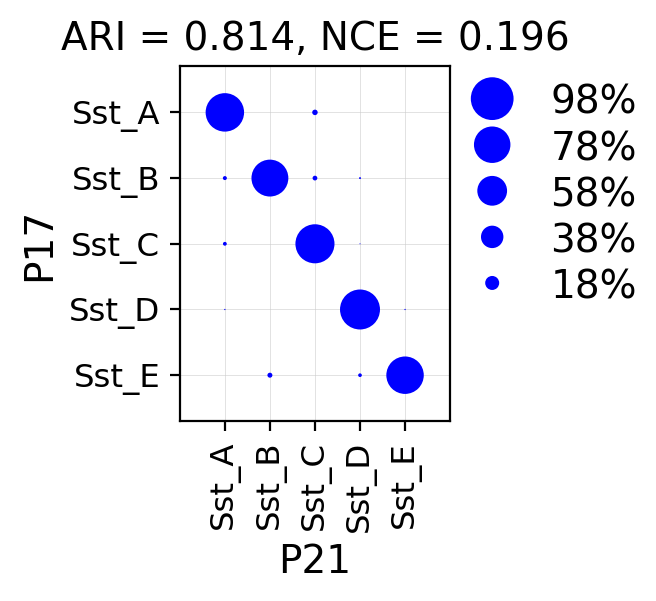

In [ ]:
mappingconfmatP17vsP21, mappingxticksP17vsP21, mappingplotP17vsP21 = tm.plotConfusionMatrix(
    ytrue = test_labelsP17vsP21,
    ypred = test_predlabelsP17vsP21,
    type = 'mapping',
    save_as = save_path + 'P17_P21/Sst_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21), calculateNCE(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21)),
    xaxislabel = 'P21',
    yaxislabel = 'P17'
    )

In [ ]:
ARI_Sst.append(adjusted_rand_score(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21))
NCE_Sst.append(calculateNCE(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21))

## Vip

In [ ]:
P17_Vip_cells = Vip_cells(P17_adata)
P21_Vip_cells = Vip_cells(P21_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P17vsP21, valid_predlabels_train_70P17vsP21, test_labelsP17vsP21, test_predlabelsP17vsP21 = tm.xgbclassifier(
    train_anndata = P21_adata[P21_Vip_cells,:],
    test_anndata = P17_adata[P17_Vip_cells,:],
    train_dict = P21_Vip_dict,
    test_dict = P17_Vip_dict
    )

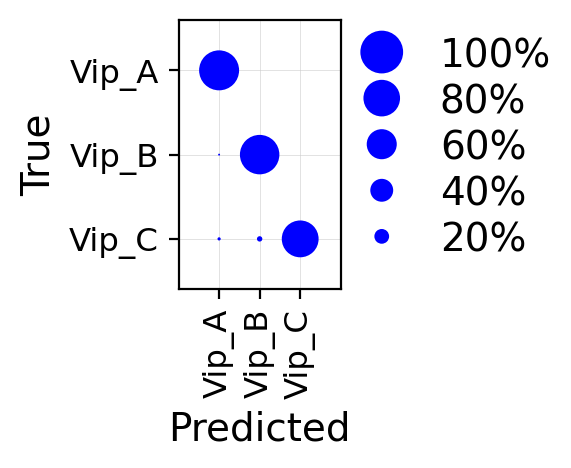

In [ ]:
validationconfmatP17vsP21, validationxticksP17vsP21, validationplotP17vsP21 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P17vsP21,
    ypred = valid_predlabels_train_70P17vsP21,
    type = 'validation',
    save_as = save_path + 'P17_P21/Vip_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

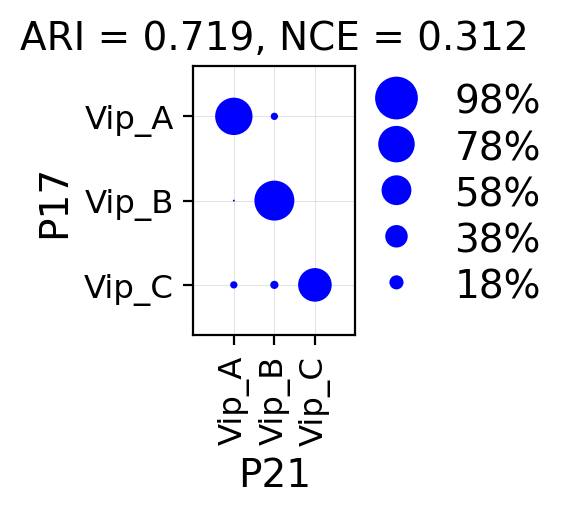

In [ ]:
mappingconfmatP17vsP21, mappingxticksP17vsP21, mappingplotP17vsP21 = tm.plotConfusionMatrix(
    ytrue = test_labelsP17vsP21,
    ypred = test_predlabelsP17vsP21,
    type = 'mapping',
    save_as = save_path + 'P17_P21/Vip_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21), calculateNCE(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21)),
    xaxislabel = 'P21',
    yaxislabel = 'P17'
    )

In [ ]:
ARI_Vip.append(adjusted_rand_score(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21))
NCE_Vip.append(calculateNCE(labels_true = test_labelsP17vsP21, labels_pred = test_predlabelsP17vsP21))

# P21-P28

In [ ]:
P21_Pvalb_dict = {'Pvalb_A':0, 'Pvalb_B':1, 'Pvalb_C':2, 'Pvalb_D':3}
P21_Sst_dict = {'Sst_A':0, 'Sst_B':1, 'Sst_C':2, 'Sst_D':3, 'Sst_E':4}
P21_Vip_dict = {'Vip_A':0, 'Vip_B':1, 'Vip_C':2}

P28_Pvalb_dict = {'Pvalb_A':0, 'Pvalb_B':1, 'Pvalb_C':2, 'Pvalb_D':3}
P28_Sst_dict = {'Sst_A':0, 'Sst_B':1, 'Sst_C':2, 'Sst_D':3, 'Sst_E':4}
P28_Vip_dict = {'Vip_A':0, 'Vip_B':1, 'Vip_C':2}

## Pvalb

In [ ]:
P21_Pvalb_cells = Pvalb_cells(P21_adata)
P28_Pvalb_cells = Pvalb_cells(P28_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P21vsP28, valid_predlabels_train_70P21vsP28, test_labelsP21vsP28, test_predlabelsP21vsP28 = tm.xgbclassifier(
    train_anndata = P28_adata[P28_Pvalb_cells,:],
    test_anndata = P21_adata[P21_Pvalb_cells,:],
    train_dict = P28_Pvalb_dict,
    test_dict = P21_Pvalb_dict
    )

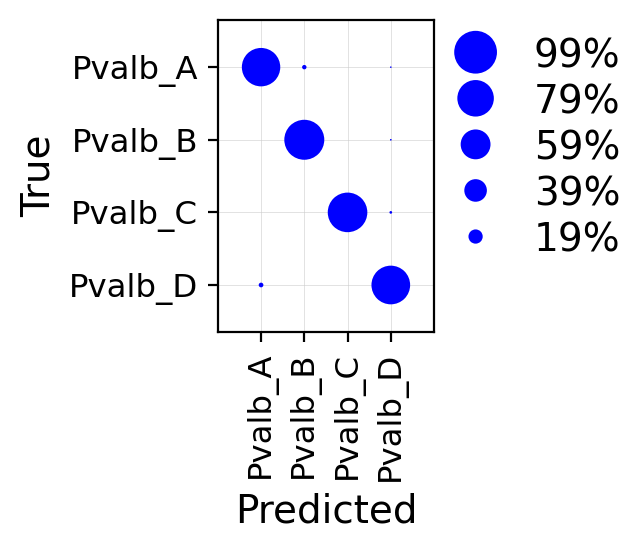

In [ ]:
validationconfmatP21vsP28, validationxticksP21vsP28, validationplotP21vsP28 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P21vsP28,
    ypred = valid_predlabels_train_70P21vsP28,
    type = 'validation',
    save_as = save_path + 'P21_P28/Pvalb_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

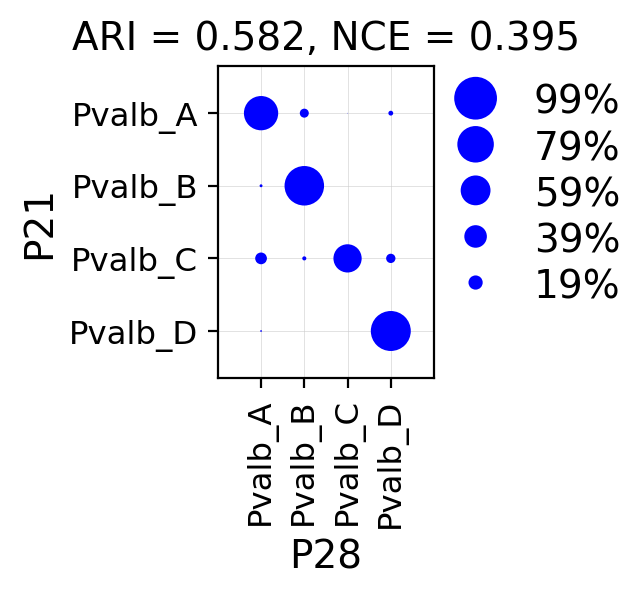

In [ ]:
mappingconfmatP21vsP28, mappingxticksP21vsP28, mappingplotP21vsP28 = tm.plotConfusionMatrix(
    ytrue = test_labelsP21vsP28,
    ypred = test_predlabelsP21vsP28,
    type = 'mapping',
    save_as = save_path + 'P21_P28/Pvalb_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28), calculateNCE(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28)),
    xaxislabel = 'P28',
    yaxislabel = 'P21'
    )

In [ ]:
ARI_Pvalb.append(adjusted_rand_score(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28))
NCE_Pvalb.append(calculateNCE(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28))

## Sst

In [ ]:
P21_Sst_cells = Sst_cells(P21_adata)
P28_Sst_cells = Sst_cells(P28_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P21vsP28, valid_predlabels_train_70P21vsP28, test_labelsP21vsP28, test_predlabelsP21vsP28 = tm.xgbclassifier(
    train_anndata = P28_adata[P28_Sst_cells,:],
    test_anndata = P21_adata[P21_Sst_cells,:],
    train_dict = P28_Sst_dict,
    test_dict = P21_Sst_dict
    )

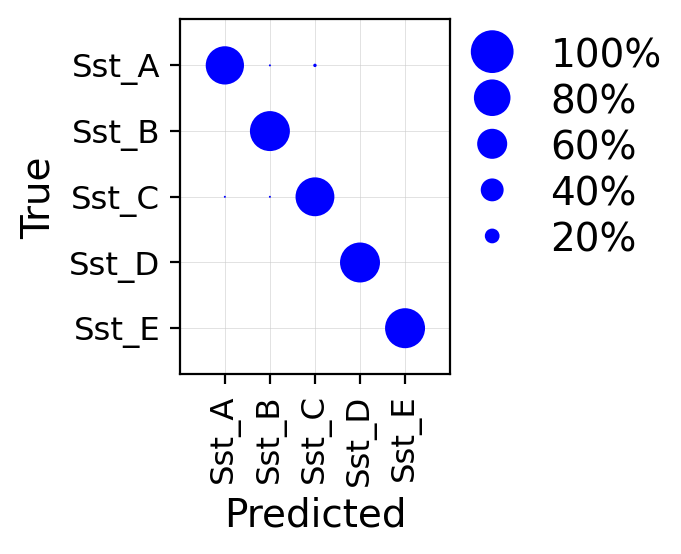

In [ ]:
validationconfmatP21vsP28, validationxticksP21vsP28, validationplotP21vsP28 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P21vsP28,
    ypred = valid_predlabels_train_70P21vsP28,
    type = 'validation',
    save_as = save_path + 'P21_P28/Sst_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

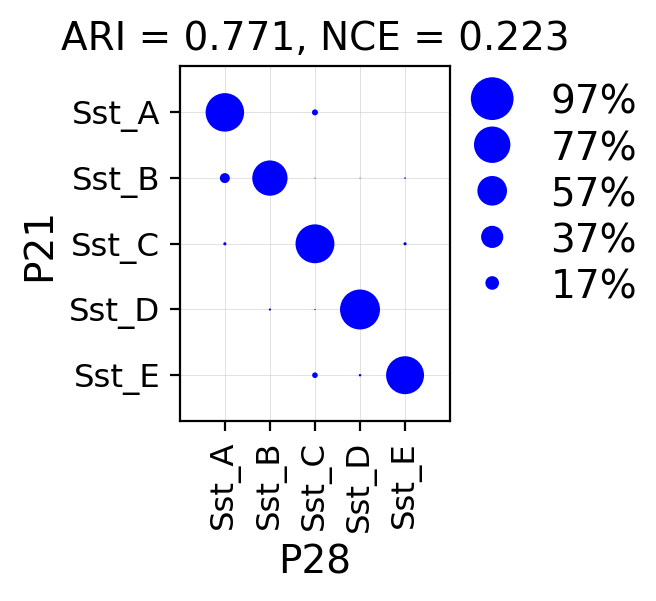

In [ ]:
mappingconfmatP21vsP28, mappingxticksP21vsP28, mappingplotP21vsP28 = tm.plotConfusionMatrix(
    ytrue = test_labelsP21vsP28,
    ypred = test_predlabelsP21vsP28,
    type = 'mapping',
    save_as = save_path + 'P21_P28/Sst_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28), calculateNCE(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28)),
    xaxislabel = 'P28',
    yaxislabel = 'P21'
    )

In [ ]:
ARI_Sst.append(adjusted_rand_score(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28))
NCE_Sst.append(calculateNCE(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28))

## Vip

In [ ]:
P21_Vip_cells = Vip_cells(P21_adata)
P28_Vip_cells = Vip_cells(P28_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P21vsP28, valid_predlabels_train_70P21vsP28, test_labelsP21vsP28, test_predlabelsP21vsP28 = tm.xgbclassifier(
    train_anndata = P28_adata[P28_Vip_cells,:],
    test_anndata = P21_adata[P21_Vip_cells,:],
    train_dict = P28_Vip_dict,
    test_dict = P21_Vip_dict
    )

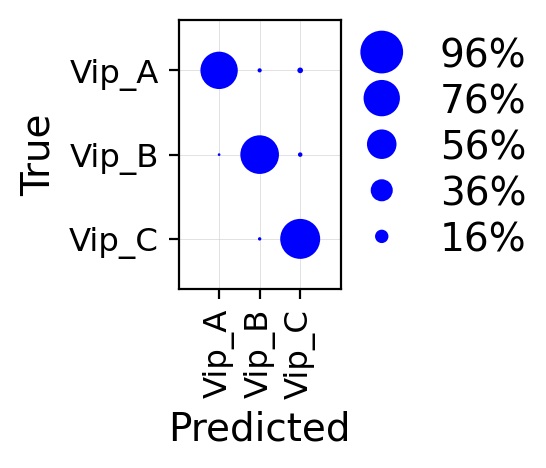

In [ ]:
validationconfmatP21vsP28, validationxticksP21vsP28, validationplotP21vsP28 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P21vsP28,
    ypred = valid_predlabels_train_70P21vsP28,
    type = 'validation',
    save_as = save_path + 'P21_P28/Vip_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

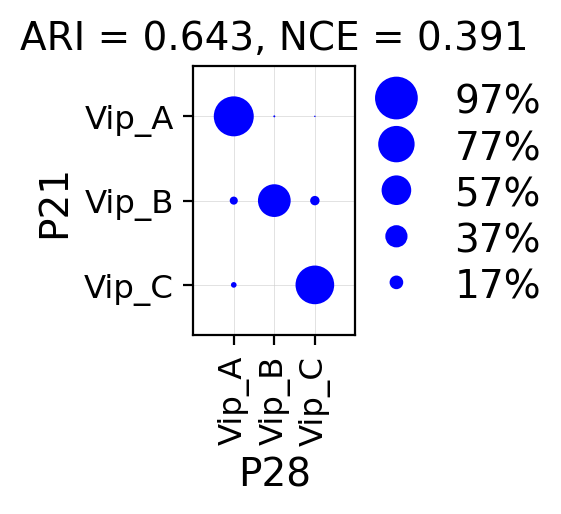

In [ ]:
mappingconfmatP21vsP28, mappingxticksP21vsP28, mappingplotP21vsP28 = tm.plotConfusionMatrix(
    ytrue = test_labelsP21vsP28,
    ypred = test_predlabelsP21vsP28,
    type = 'mapping',
    save_as = save_path + 'P21_P28/Vip_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28), calculateNCE(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28)),
    xaxislabel = 'P28',
    yaxislabel = 'P21'
    )

In [ ]:
ARI_Vip.append(adjusted_rand_score(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28))
NCE_Vip.append(calculateNCE(labels_true = test_labelsP21vsP28, labels_pred = test_predlabelsP21vsP28))

# P28-P38

In [ ]:
P28_Pvalb_dict = {'Pvalb_A':0, 'Pvalb_B':1, 'Pvalb_C':2, 'Pvalb_D':3}
P28_Sst_dict = {'Sst_A':0, 'Sst_B':1, 'Sst_C':2, 'Sst_D':3, 'Sst_E':4}
P28_Vip_dict = {'Vip_A':0, 'Vip_B':1, 'Vip_C':2}

P38_Pvalb_dict = {'Pvalb_A':0, 'Pvalb_B':1, 'Pvalb_C':2, 'Pvalb_D':3}
P38_Sst_dict = {'Sst_A':0, 'Sst_B':1, 'Sst_C':2, 'Sst_D':3, 'Sst_E':4}
P38_Vip_dict = {'Vip_A':0, 'Vip_B':1, 'Vip_C':2}

## Pvalb

In [ ]:
P28_Pvalb_cells = Pvalb_cells(P28_adata)
P38_Pvalb_cells = Pvalb_cells(P38_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P28vsP38, valid_predlabels_train_70P28vsP38, test_labelsP28vsP38, test_predlabelsP28vsP38 = tm.xgbclassifier(
    train_anndata = P38_adata[P38_Pvalb_cells,:],
    test_anndata = P28_adata[P28_Pvalb_cells,:],
    train_dict = P38_Pvalb_dict,
    test_dict = P28_Pvalb_dict
    )

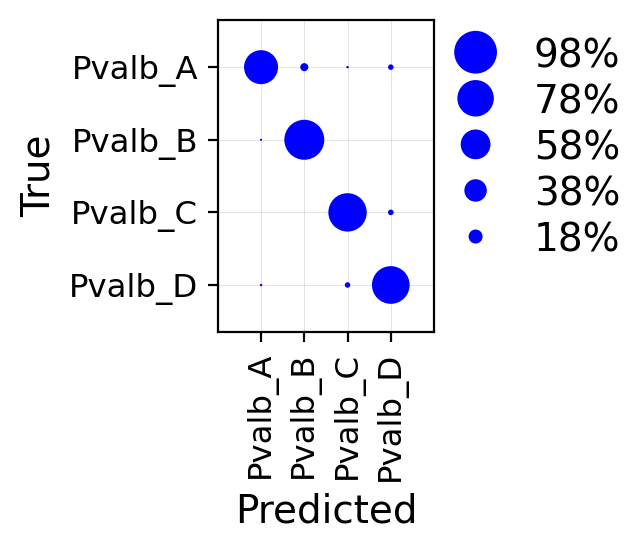

In [ ]:
validationconfmatP28vsP38, validationxticksP28vsP38, validationplotP28vsP38 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P28vsP38,
    ypred = valid_predlabels_train_70P28vsP38,
    type = 'validation',
    save_as = save_path + 'P28_P38/Pvalb_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

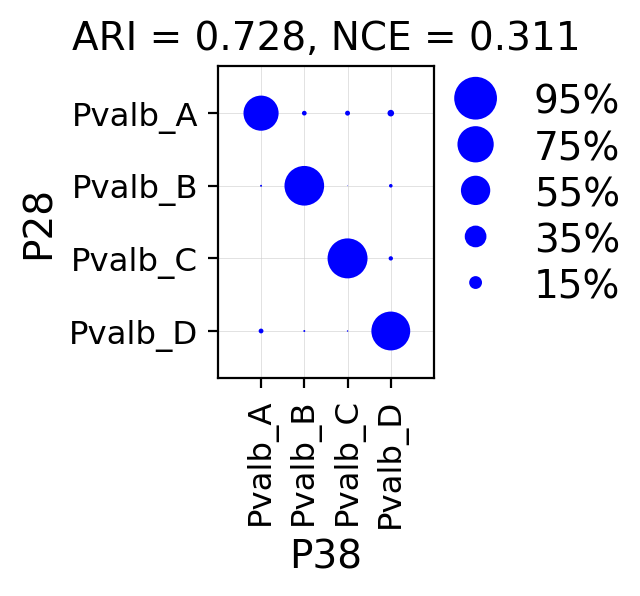

In [ ]:
mappingconfmatP28vsP38, mappingxticksP28vsP38, mappingplotP28vsP38 = tm.plotConfusionMatrix(
    ytrue = test_labelsP28vsP38,
    ypred = test_predlabelsP28vsP38,
    type = 'mapping',
    save_as = save_path + 'P28_P38/Pvalb_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38), calculateNCE(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38)),
    xaxislabel = 'P38',
    yaxislabel = 'P28'
    )

In [ ]:
ARI_Pvalb.append(adjusted_rand_score(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38))
NCE_Pvalb.append(calculateNCE(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38))

## Sst

In [ ]:
P28_Sst_cells = Sst_cells(P28_adata)
P38_Sst_cells = Sst_cells(P38_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P28vsP38, valid_predlabels_train_70P28vsP38, test_labelsP28vsP38, test_predlabelsP28vsP38 = tm.xgbclassifier(
    train_anndata = P38_adata[P38_Sst_cells,:],
    test_anndata = P28_adata[P28_Sst_cells,:],
    train_dict = P38_Sst_dict,
    test_dict = P28_Sst_dict
    )

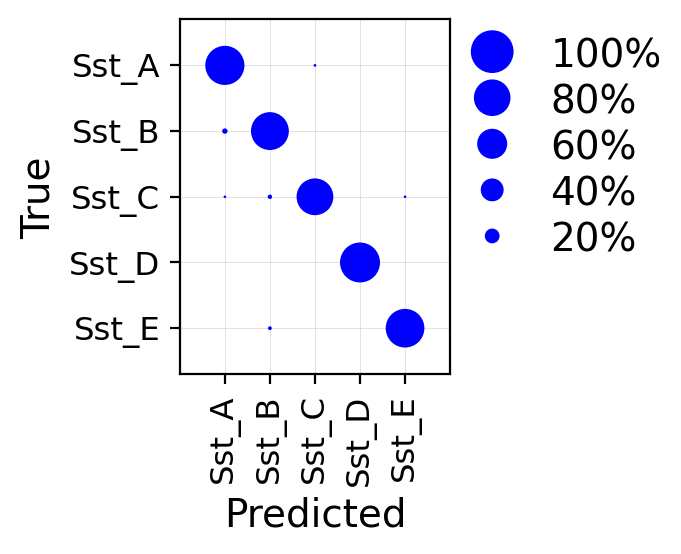

In [ ]:
validationconfmatP28vsP38, validationxticksP28vsP38, validationplotP28vsP38 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P28vsP38,
    ypred = valid_predlabels_train_70P28vsP38,
    type = 'validation',
    save_as = save_path + 'P28_P38/Sst_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

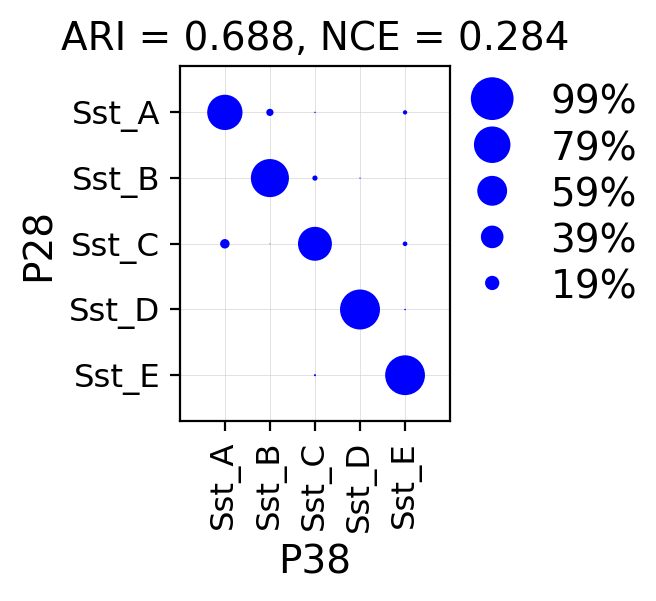

In [ ]:
mappingconfmatP28vsP38, mappingxticksP28vsP38, mappingplotP28vsP38 = tm.plotConfusionMatrix(
    ytrue = test_labelsP28vsP38,
    ypred = test_predlabelsP28vsP38,
    type = 'mapping',
    save_as = save_path + 'P28_P38/Sst_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38), calculateNCE(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38)),
    xaxislabel = 'P38',
    yaxislabel = 'P28'
    )

In [ ]:
ARI_Sst.append(adjusted_rand_score(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38))
NCE_Sst.append(calculateNCE(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38))

## Vip

In [ ]:
P28_Vip_cells = Vip_cells(P28_adata)
P38_Vip_cells = Vip_cells(P38_adata)

In [ ]:
tm = TimeMapping()

In [ ]:
validation_label_train_70P28vsP38, valid_predlabels_train_70P28vsP38, test_labelsP28vsP38, test_predlabelsP28vsP38 = tm.xgbclassifier(
    train_anndata = P38_adata[P38_Vip_cells,:],
    test_anndata = P28_adata[P28_Vip_cells,:],
    train_dict = P38_Vip_dict,
    test_dict = P28_Vip_dict
    )

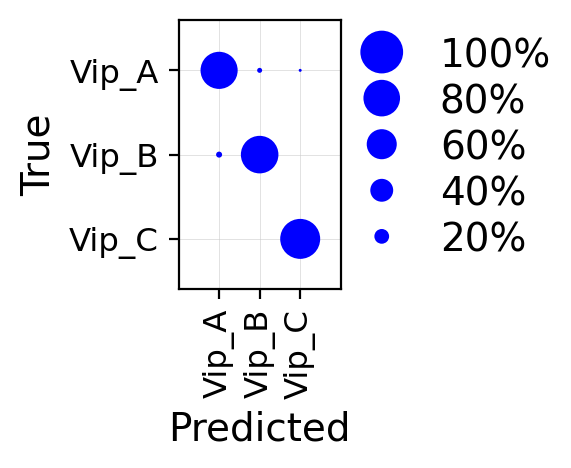

In [ ]:
validationconfmatP28vsP38, validationxticksP28vsP38, validationplotP28vsP38 = tm.plotConfusionMatrix(
    ytrue = validation_label_train_70P28vsP38,
    ypred = valid_predlabels_train_70P28vsP38,
    type = 'validation',
    save_as = save_path + 'P28_P38/Vip_validation.pdf',
    title = '',
    xaxislabel = 'Predicted',
    yaxislabel = 'True'
    )

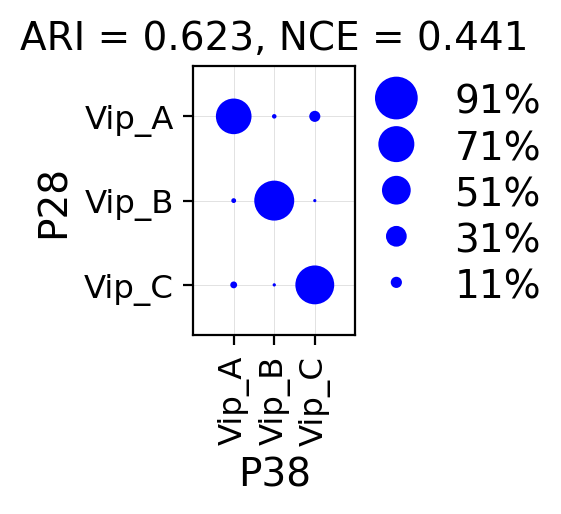

In [ ]:
mappingconfmatP28vsP38, mappingxticksP28vsP38, mappingplotP28vsP38 = tm.plotConfusionMatrix(
    ytrue = test_labelsP28vsP38,
    ypred = test_predlabelsP28vsP38,
    type = 'mapping',
    save_as = save_path + 'P28_P38/Vip_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38), calculateNCE(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38)),
    xaxislabel = 'P38',
    yaxislabel = 'P28'
    )

In [ ]:
ARI_Vip.append(adjusted_rand_score(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38))
NCE_Vip.append(calculateNCE(labels_true = test_labelsP28vsP38, labels_pred = test_predlabelsP28vsP38))

# Bar Plot

In [ ]:
np.save(save_path + 'ARI_Pvalb', ARI_Pvalb)
np.save(save_path + 'ARI_Sst', ARI_Sst)
np.save(save_path + 'ARI_Vip', ARI_Vip)

In [ ]:
np.save(save_path + 'NCE_Pvalb', NCE_Pvalb)
np.save(save_path + 'NCE_Sst', NCE_Sst)
np.save(save_path + 'NCE_Vip', NCE_Vip)

In [ ]:
ARI_Pvalb = np.load(save_path + 'ARI_Pvalb.npy')
ARI_Sst = np.load(save_path + 'ARI_Sst.npy')
ARI_Vip = np.load(save_path + 'ARI_Vip.npy')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


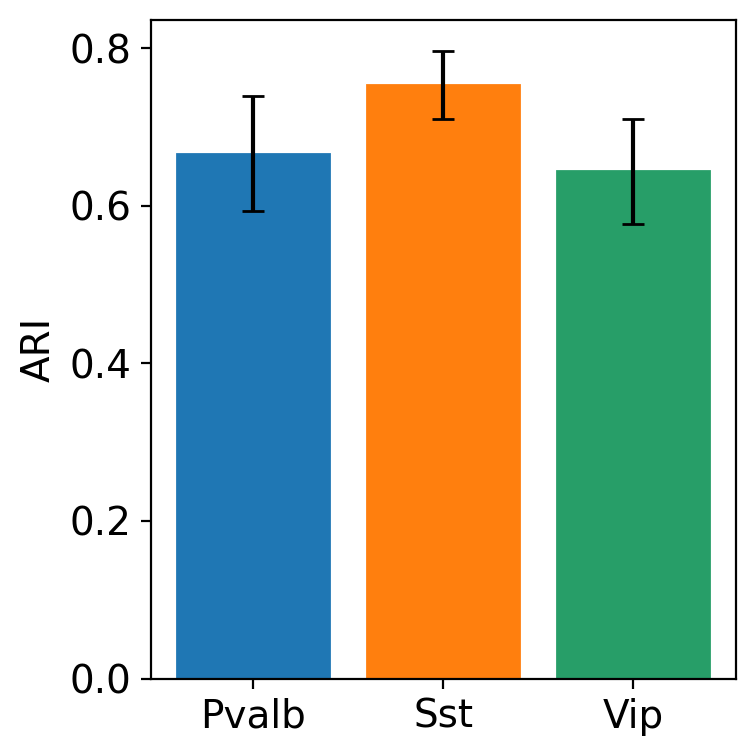

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (4,4))
timepair = [0,1,2]
axes.set_ylabel('ARI')
fl_mean = [np.mean(ARI_Pvalb), np.mean(ARI_Sst), np.mean(ARI_Vip)]
fl_std = [np.std(ARI_Pvalb), np.std(ARI_Sst), np.std(ARI_Vip)]
barplot = axes.bar(timepair, fl_mean, yerr = fl_std, capsize = 4)
barplot[0].set_color('C0')
barplot[1].set_color('C1')
barplot[2].set_color('C2')
axes.set_ylim(bottom = 0)
axes.set_xticks(timepair)
axes.set_xticklabels(['Pvalb', 'Sst', 'Vip'], rotation=0)
axes.tick_params(axis='both', labelsize='medium')
axes.grid(False)
fig.tight_layout()
fig.savefig(save_path + 'ARI_Barplot.pdf')

In [ ]:
Pvalb_Vip_t, Pvalb_Vip_p = sp.stats.ttest_ind(a = ARI_Pvalb, b = ARI_Vip)

Pvalb_Sst_t, Pvalb_Sst_p = sp.stats.ttest_ind(a = ARI_Pvalb, b = ARI_Sst)

Sst_Vip_t, Sst_Vip_p = sp.stats.ttest_ind(a = ARI_Sst, b = ARI_Vip)

In [ ]:
print(Pvalb_Vip_p, Pvalb_Sst_p, Sst_Vip_p)

0.6655690965548052 0.07203614056770487 0.02470044593770013
